In [1]:
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
# import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx

import networkx as nx
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def check_graph(data):
    '''グラフ情報を表示'''
    print("グラフ構造:", data)
    print("グラフのキー: ", data.keys)
    print("ノード数:", data.num_nodes)
    print("エッジ数:", data.num_edges)
    print("ノードの特徴量数:", data.num_node_features)
    print("孤立したノードの有無:", data.contains_isolated_nodes())
    print("自己ループの有無:", data.contains_self_loops())
    print("====== ノードの特徴量:x ======")
    print(data['x'])
    print("====== ノードのクラス:y ======")
    print(data['y'])
    print("========= エッジ形状 =========")
    print(data['edge_index'])

In [3]:
# データセットをダウンロード
dataset = KarateClub()

print("グラフ数:", len(dataset))  # グラフ数: 1
print("クラス数:", dataset.num_classes)  # クラス数: 2

data = dataset[0]  # 1つめのグラフ
check_graph(data)


グラフ数: 1
クラス数: 4
グラフ構造: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
グラフのキー:  ['y', 'edge_index', 'train_mask', 'x']
ノード数: 34
エッジ数: 156
ノードの特徴量数: 34
孤立したノードの有無: False
自己ループの有無: False
====== ノードの特徴量:x ======
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
====== ノードのクラス:y ======
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
========= エッジ形状 =========
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 

/Users/WatanabeShingo/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/Users/WatanabeShingo/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


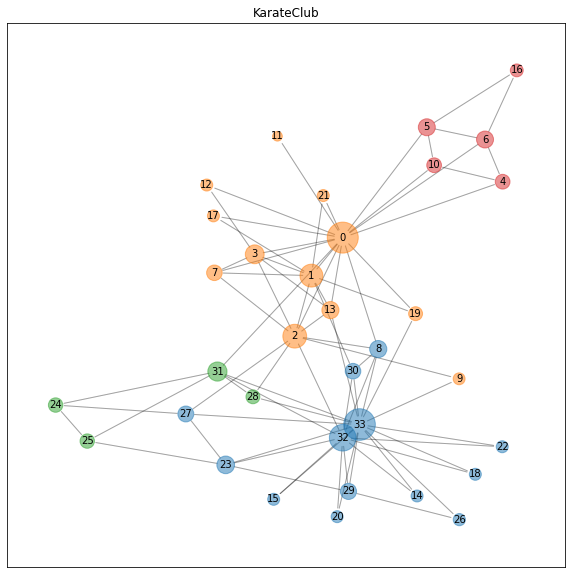

In [4]:
# networkxのグラフに変換
nxg = to_networkx(data)

# 可視化のためのページランク計算
pr = nx.pagerank(nxg)
pr_max = np.array(list(pr.values())).max()

# 可視化する際のノード位置
draw_pos = nx.spring_layout(nxg, seed=0)

# ノードの色設定
cmap = plt.get_cmap('tab10')
labels = data.y.numpy()
colors = [cmap(l) for l in labels]

# 図のサイズ
plt.figure(figsize=(10, 10))

# 描画
nx.draw_networkx_nodes(nxg,
                       draw_pos,
                       node_size=[v / pr_max * 1000 for v in pr.values()],
                       node_color=colors, alpha=0.5)
nx.draw_networkx_edges(nxg, draw_pos, arrowstyle='-', alpha=0.2)
nx.draw_networkx_labels(nxg, draw_pos, font_size=10)

plt.title('KarateClub')
plt.show()


In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hidden_size = 5
        self.conv1 = GCNConv(dataset.num_node_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)


In [6]:
# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデルのインスタンス生成
model = Net()
# print(model)

# モデルを訓練モードに設定
model.train()


Net(
  (conv1): GCNConv(34, 5)
  (conv2): GCNConv(5, 4)
)

In [7]:
# input data
data = dataset[0]

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# learnig loop
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))


Epoch 0 | Loss: 1.3959
Epoch 1 | Loss: 1.3787
Epoch 2 | Loss: 1.3627
Epoch 3 | Loss: 1.3468
Epoch 4 | Loss: 1.3315
Epoch 5 | Loss: 1.3171
Epoch 6 | Loss: 1.3032
Epoch 7 | Loss: 1.2897
Epoch 8 | Loss: 1.2768
Epoch 9 | Loss: 1.2647
Epoch 10 | Loss: 1.2533
Epoch 11 | Loss: 1.2423
Epoch 12 | Loss: 1.2315
Epoch 13 | Loss: 1.2208
Epoch 14 | Loss: 1.2102
Epoch 15 | Loss: 1.1999
Epoch 16 | Loss: 1.1899
Epoch 17 | Loss: 1.1799
Epoch 18 | Loss: 1.1700
Epoch 19 | Loss: 1.1601
Epoch 20 | Loss: 1.1501
Epoch 21 | Loss: 1.1402
Epoch 22 | Loss: 1.1302
Epoch 23 | Loss: 1.1201
Epoch 24 | Loss: 1.1099
Epoch 25 | Loss: 1.0995
Epoch 26 | Loss: 1.0889
Epoch 27 | Loss: 1.0782
Epoch 28 | Loss: 1.0674
Epoch 29 | Loss: 1.0564
Epoch 30 | Loss: 1.0453
Epoch 31 | Loss: 1.0334
Epoch 32 | Loss: 1.0214
Epoch 33 | Loss: 1.0089
Epoch 34 | Loss: 0.9960
Epoch 35 | Loss: 0.9826
Epoch 36 | Loss: 0.9679
Epoch 37 | Loss: 0.9523
Epoch 38 | Loss: 0.9366
Epoch 39 | Loss: 0.9210
Epoch 40 | Loss: 0.9051
Epoch 41 | Loss: 0.8891
Ep

In [11]:
# モデルを評価モードに設定
model.eval()

# 推論
_, pred = model(data).max(dim=1)

print("結果：", pred)
print("真値：", data.y)


結果： tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
真値： tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])
